In [1]:
using CairoMakie

import LilGuys as lguys
using Arya

In [2]:
import TOML

In [3]:
using Measurements

In [4]:
using LilGuys

In [5]:
function sigma_axis(gp; kwargs...) 
	ax = Axis(gp, 
		xlabel=log_r_label,
		ylabel = L"\log \Sigma\ / \textrm{(stars/arcmin^2)}",
        limits=(-1, 2, -2, 2.5)
		;kwargs...
	)

	return fig, ax
end

sigma_axis (generic function with 1 method)

In [6]:
prof_expected = lguys.SurfaceDensityProfile(joinpath(ENV["DWARFS_ROOT"], "observations/sculptor/density_profiles/fiducial_profile.toml"))

SurfaceDensityProfile("arcmin", "", [-0.9937001606211208, -0.9437001606211208, -0.8937001606211208, -0.8437001606211207, -0.7937001606211208, -0.7437001606211208, -0.6937001606211207, -0.6437001606211208, -0.5937001606211207, -0.5437001606211208  …  1.8062998393788794, 1.8562998393788794, 1.9062998393788795, 1.9562998393788793, 2.0062998393788796, 2.0562998393788794, 2.106299839378879, 2.1562998393788795, 2.2062998393788793, 2.2562998393788796], [-1.0187001606211208, -0.9687001606211207, -0.9187001606211208, -0.8687001606211208, -0.8187001606211208, -0.7687001606211208, -0.7187001606211207, -0.6687001606211207, -0.6187001606211208, -0.5687001606211208  …  1.8312998393788793, 1.8812998393788796, 1.9312998393788794, 1.9812998393788792, 2.0312998393788795, 2.0812998393788793, 2.1312998393788796, 2.1812998393788794, 2.231299839378879, 2.2812998393788795], [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0  …  37.0, 22.0, 13.0, 10.0, 4.0, 1.0, 1.0, 1.0, 0.0, 0.0], Float64[], LilGuys.Measurem

In [7]:
log_r_label = "log r / arcmin"
log_sigma_label = L"\log\, \Sigma/\Sigma_0"

L"$\log\, \Sigma/\Sigma_0$"

In [8]:
function plot_finals(models)
    
    fig = Figure()
    Axis(fig[1, 1], 
        xlabel = log_r_label, 
        ylabel = log_sigma_label,
        limits = (-0.5, 2.3, -2, 2)
        )

	errorscatter!(LilGuys.log_radii(prof_expected), LilGuys.log_surface_density(prof_expected),
		yerror=LilGuys.sym_err.(LilGuys.log_surface_density(prof_expected)),
		color=:black,
        label="J+24",
	)

    for (label, model) in models
    	lines!(LilGuys.log_radii(model), LilGuys.log_surface_density(model.log_Sigma) .|> middle, 
    			label=label)
    end

	axislegend()

	fig
end

plot_finals (generic function with 1 method)

In [9]:
function plot_ini_fin(profs, model, normalization=0; 
        limits=(-0.5, 2.3, -2, 2),
        r_b = NaN,
        kwargs...
    )
    
    fig = Figure()
    Axis(fig[1, 1];
        xlabel = log_r_label, 
        ylabel = log_sigma_label,
        limits = limits, 
        kwargs...
    )

	errorscatter!(LilGuys.log_radii(prof_expected), LilGuys.log_surface_density(prof_expected),
		#yerr=prof_expected.log_Sigma_err,
		color=:black,
        label="J+24",
	)

    for (label, prof) in profs
        lines!(LilGuys.log_radii(prof), LilGuys.log_surface_density(prof) .+ normalization, 
                label=label)
    end


    if model !== nothing

        x = LinRange(-2, 2.5, 1000)
        r = 10 .^ x
        y = lguys.calc_Σ.(model, r)
    
        r_scale = lguys.kpc_to_arcmin(1, profs[1].second.distance)
    
    
        x = x .+ log10(r_scale)
        y .*= 1 / r_scale ^ 2
    
        lines!(x, log10.(y) .+ normalization, linestyle=:dot, color=:black, label="expected")

    end
    
    if r_b !== NaN
        dy = limits[4]-limits[3]
        dx = limits[2] - limits[1]
        
        x0 = limits[1]
        y0 = limits[3]

        a = log10(r_b)
        _, prof = profs[end]
        idx = argmin(abs.(LilGuys.log_radii(prof) .- a))
        b = prof.log_Sigma[idx] + normalization .+ 0.1dy
        va = 0
        vb = -0.05dy
        
        arrows!([a], [b], [va], [vb])
        println(a, ", ", b)
        text!(a, b, text=L"r_b")

    end

	axislegend(position=:lb)


	fig
end

plot_ini_fin (generic function with 2 methods)

In [10]:
function mean_groups_with_uncertainties(data::Vector{T}, uncertainties::Vector{T}, n::Int) where T
    num_full_groups = div(length(data), n)
    remainder = length(data) % n
    
    # Create arrays to store the means and their uncertainties
    means = Vector{T}(undef, num_full_groups + (remainder > 0 ? 1 : 0))
    uncertainties_mean = Vector{T}(undef, length(means))
    
    # Function to compute weighted mean and uncertainty of the mean
    function weighted_mean(data_group, uncertainty_group)
        weights = 1 ./ (uncertainty_group .^ 2)
        m = sum(weights .* data_group) / sum(weights)
        uncertainty_of_mean = sqrt(1 / sum(weights))
        return (m, uncertainty_of_mean)
    end

    # Calculate the means and uncertainties of full groups
    for i in 1:num_full_groups
        start_index = (i - 1) * n + 1
        end_index = i * n
        means[i], uncertainties_mean[i] = weighted_mean(data[start_index:end_index], uncertainties[start_index:end_index])
    end
    
    # Handle the remaining data, if any
    if remainder != 0
        start_index = num_full_groups * n + 1
        means[end], uncertainties_mean[end] = weighted_mean(data[start_index:end], uncertainties[start_index:end])
    end
    
    return means, uncertainties_mean
end


mean_groups_with_uncertainties (generic function with 1 method)

In [26]:
?LilGuys.Gamma

No documentation found.

Binding `LilGuys.Gamma` does not exist.


In [27]:
function plot_ini_fin_slope(profs, model; 
        binsize=3,
        obs_binsize=2,
        limits=(-0.5, 2.3, -2, 2),
        r_b = NaN,
        figsize=(600, 300),
        kwargs...
    )
    
    fig = Figure(size=figsize)
    ax = Axis(fig[1, 1];
        xlabel = log_r_label, 
        ylabel = L"\Gamma",
        limits = limits, 
        kwargs...
    )

    ax_lin = Axis(fig[1, 2];
        xlabel = "r / arcmin", 
        ylabel = L"\Gamma",
        limits = (0, 10^limits[2], limits[3], limits[4]), 
        kwargs...
    )

    x = LilGuys.log_radii(prof_expected) 
    y = prof_expected.Gamma
    ye = LilGuys.sym_error.(y)

    x = mean_groups(x, obs_binsize)
    y, ye = mean_groups_with_uncertainties(y, ye, obs_binsize)
    
	errorscatter!(ax, x, y,
		yerror=ye,
		color=:black,
        label="J+24",
	)


    errorscatter!(ax_lin, 10 .^ x, y,
		yerr=ye,
		color=:black,
	)

    for (label, prof) in profs
        x = mean_groups(LilGuys.log_radii(prof), binsize)
        y = mean_groups(prof.Gamma, binsize)
        lines!(ax, x, y, label=label)
        lines!(ax_lin, 10 .^ x, y)
    end


    if model !== nothing

        x = LinRange(-2, 2.5, 1000)
        r = 10 .^ x
        y = lguys.calc_Σ.(model, r)
    
        r_scale = lguys.kpc_to_arcmin(1, profs[1].second.distance)
    
    
        x = x .+ log10(r_scale)
        y .*= 1 / r_scale ^ 2
        gamma = lguys.gradient(log10.(y), x)
    
        lines!(ax, x, gamma, linestyle=:dot, color=:black, label="expected")
        lines!(ax_lin, 10 .^ x, gamma, linestyle=:dot, color=:black, label="expected")

    end
    
    if r_b !== NaN
        dy = limits[4]-limits[3]
        dx = limits[2] - limits[1]
        
        x0 = limits[1]
        y0 = limits[3]

        a = log10(r_b)
        _, prof = profs[end]
        idx = argmin(abs.(prof.log_r .- a))
        b = prof.Gamma[idx] .+ 0.1dy
        va = 0
        vb = -0.05dy
        
        arrows!(ax, [a], [b], [va], [vb])
        println(a, ", ", b)
        text!(ax, a, b, text=L"r_b")

    end


    linkyaxes!(ax, ax_lin)
    hideydecorations!(ax_lin, grid=false, ticks=false)
    
	axislegend(ax, position=:lb)

	fig
end

plot_ini_fin_slope (generic function with 1 method)

In [12]:
import StatsBase: mean

In [13]:
function mean_groups(data::AbstractVector{T}, n::Int) where T
    num_full_groups = div(length(data), n)
    remainder = length(data) % n
    
    # Create an array to store the means
    means = Vector{T}(undef, num_full_groups + (remainder > 0 ? 1 : 0))
    
    # Calculate the means of full groups
    for i in 1:num_full_groups
        start_index = (i - 1) * n + 1
        end_index = i * n
        means[i] = mean(data[start_index:end_index])
    end
    
    # Handle the remaining data, if any
    if remainder != 0
        start_index = num_full_groups * n + 1
        means[end] = mean(data[start_index:end])
    end
    
    return means
end

mean_groups (generic function with 1 method)

In [14]:
mean_groups(1:10, 3)

4-element Vector{Int64}:
  2
  5
  8
 10

In [15]:
function get_log_Σ_0(prof, χ2_max=1)

    local log_Σ_0, log_Σ_0_err

    pre_filt = isfinite.(LilGuys.log_surface_density(prof))
    log_r = LilGuys.log_radii(prof)[pre_filt]
    log_Σ = LilGuys.log_surface_density(prof)[pre_filt]
    log_Σ_err = LilGuys.log_surface_density_err(prof)[pre_filt]
    @assert issorted(log_r)

    for i in eachindex(log_r)
        filt = 1:i
        log_Σ_0 = lguys.mean(log_Σ[filt] .± log_Σ_err[filt])
        log_Σ_0_err = Measurements.uncertainty.(log_Σ_0)
        log_Σ_0 = Measurements.value(log_Σ_0)
        χ2 = @. (log_Σ_0 - log_Σ)^2 / (log_Σ_err + log_Σ_0_err)^2

        χ2_norm = lguys.mean(χ2[filt])

        if χ2_norm .> χ2_max
            @info "max radius of $(log_r[i])"
            break
        end
    end
    
    return log_Σ_0, log_Σ_0_err
end

get_log_Σ_0 (generic function with 2 methods)

In [16]:
function get_normalization(prof_f, prof_expected=prof_expected)
    log_Σ_0_obs, _ = get_log_Σ_0(prof_expected)
    log_Σ_0, _ = get_log_Σ_0(prof_f)

    return log_Σ_0_obs - log_Σ_0
end

get_normalization (generic function with 2 methods)

In [17]:
modelsdir = ENV["DWARFS_ROOT"] * "/analysis/sculptor/"

"/cosma/home/durham/dc-boye1/data/dwarfs/analysis/sculptor/"

In [18]:
function read_profiles(filename, starsname)
    
    # prof_iso_i = lguys.StellarProfile(modelsdir * filename * "/stars/$starsname/iso_initial_profile.toml")
    # prof_iso_p = lguys.StellarProfile(modelsdir * filename * "/stars/$starsname/iso_paint_profile.toml")
    # prof_iso_f = lguys.StellarProfile(modelsdir * filename * "/stars/$starsname/iso_final_profile.toml")
    
    prof_i = lguys.SurfaceDensityProfile(modelsdir * filename * "/stars/$starsname/initial_profile.toml")
    prof_f = lguys.SurfaceDensityProfile(modelsdir * filename * "/stars/$starsname/final_profile.toml")
    prof_ana = nothing#lguys.SurfaceDensityProfile(modelsdir * filename * "/../stars/$starsname/profile.toml")

    
    profs = [
        #"iso initial" => prof_iso_i,
        #"stars initial" => prof_iso_p,
        #"iso final" => prof_iso_f,
        "initial" => prof_i,
        "present day" => prof_f,
    ]

    return profs, prof_ana
end

read_profiles (generic function with 1 method)

In [19]:
function read_profiles_simple(filename, starsname)
    
    prof_iso_p = lguys.StellarProfile(modelsdir * filename * "/stars/$starsname/iso_paint_profile.toml")
    prof_f = lguys.StellarProfile(modelsdir * filename * "/stars/$starsname/final_profile.toml")

    profs = [
        "initial" => prof_iso_p,
        "final" => prof_f,
    ]

    return profs
end

read_profiles_simple (generic function with 1 method)

In [29]:
#plot_ini_fin_slope([], nothing, limits=(-0.8, 1.95, -6.5, 4),)

In [30]:
LilGuys.log_surface_density_err

log_surface_density_err (generic function with 1 method)

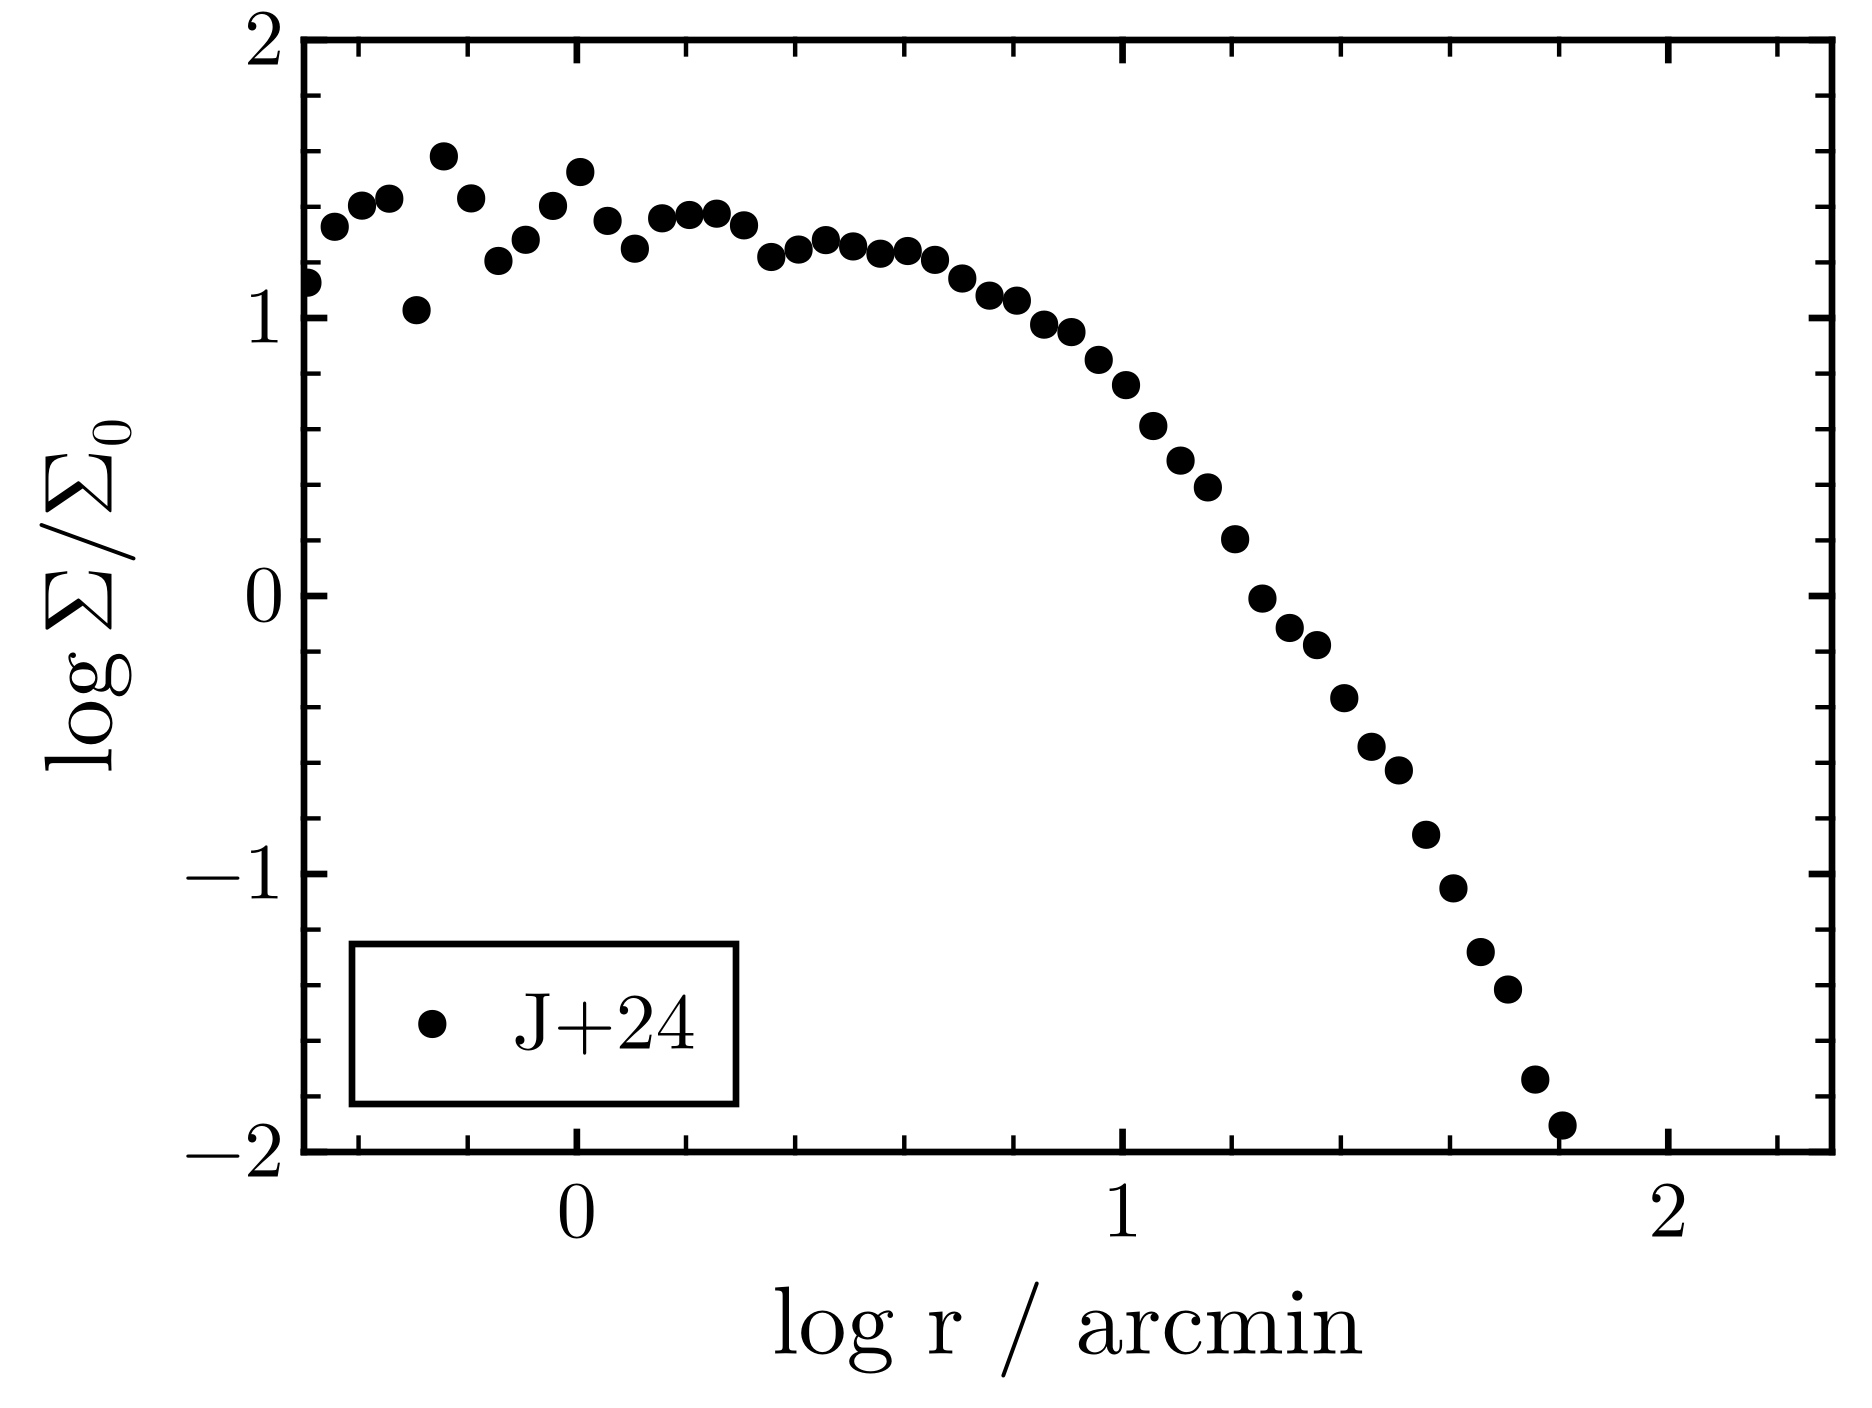

In [31]:
plot_ini_fin([], nothing)

# New

In [40]:
modeldir = "1e6_new_v31_r3.2/orbit_smallperi"

"1e6_new_v31_r3.2/orbit_smallperi"

In [41]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

Dict{String, Any} with 18 entries:
  "theta0"            => -40.016
  "idx_peris"         => [18, 52, 86, 120, 153, 186]
  "dec_f"             => -35.8947
  "pmra_f"            => 0.141323
  "t_f_gyr"           => 0.0433503
  "radial_velocity_f" => -0.194349
  "t_last_peri"       => 0.470994
  "apocentre"         => [94.6803, 94.0749, 93.6361, 93.5378, 93.372]
  "period"            => 1.5843
  "pericentre"        => 42.4438
  "idx_peri"          => 186
  "idx_f"             => 196
  "idx_apos"          => [35, 69, 103, 136, 170, 203]
  "t_peris"           => [170.024, 510.073, 850.122, 1189.91, 1520.13, 1850.08]
  "pmdec_f"           => -0.194349
  "distance_f"        => 80.9716
  "t_apos"            => [340.049, 680.098, 1019.89, 1350.1, 1689.89, 2020.11]
  "ra_f"              => 17.2364

In [45]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [46]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

# r_b = lguys.break_radius(prof_f. / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
# r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


[ Info: max radius of 0.7562998393788792
[ Info: max radius of 0.5825152061590549


3.90901881787255

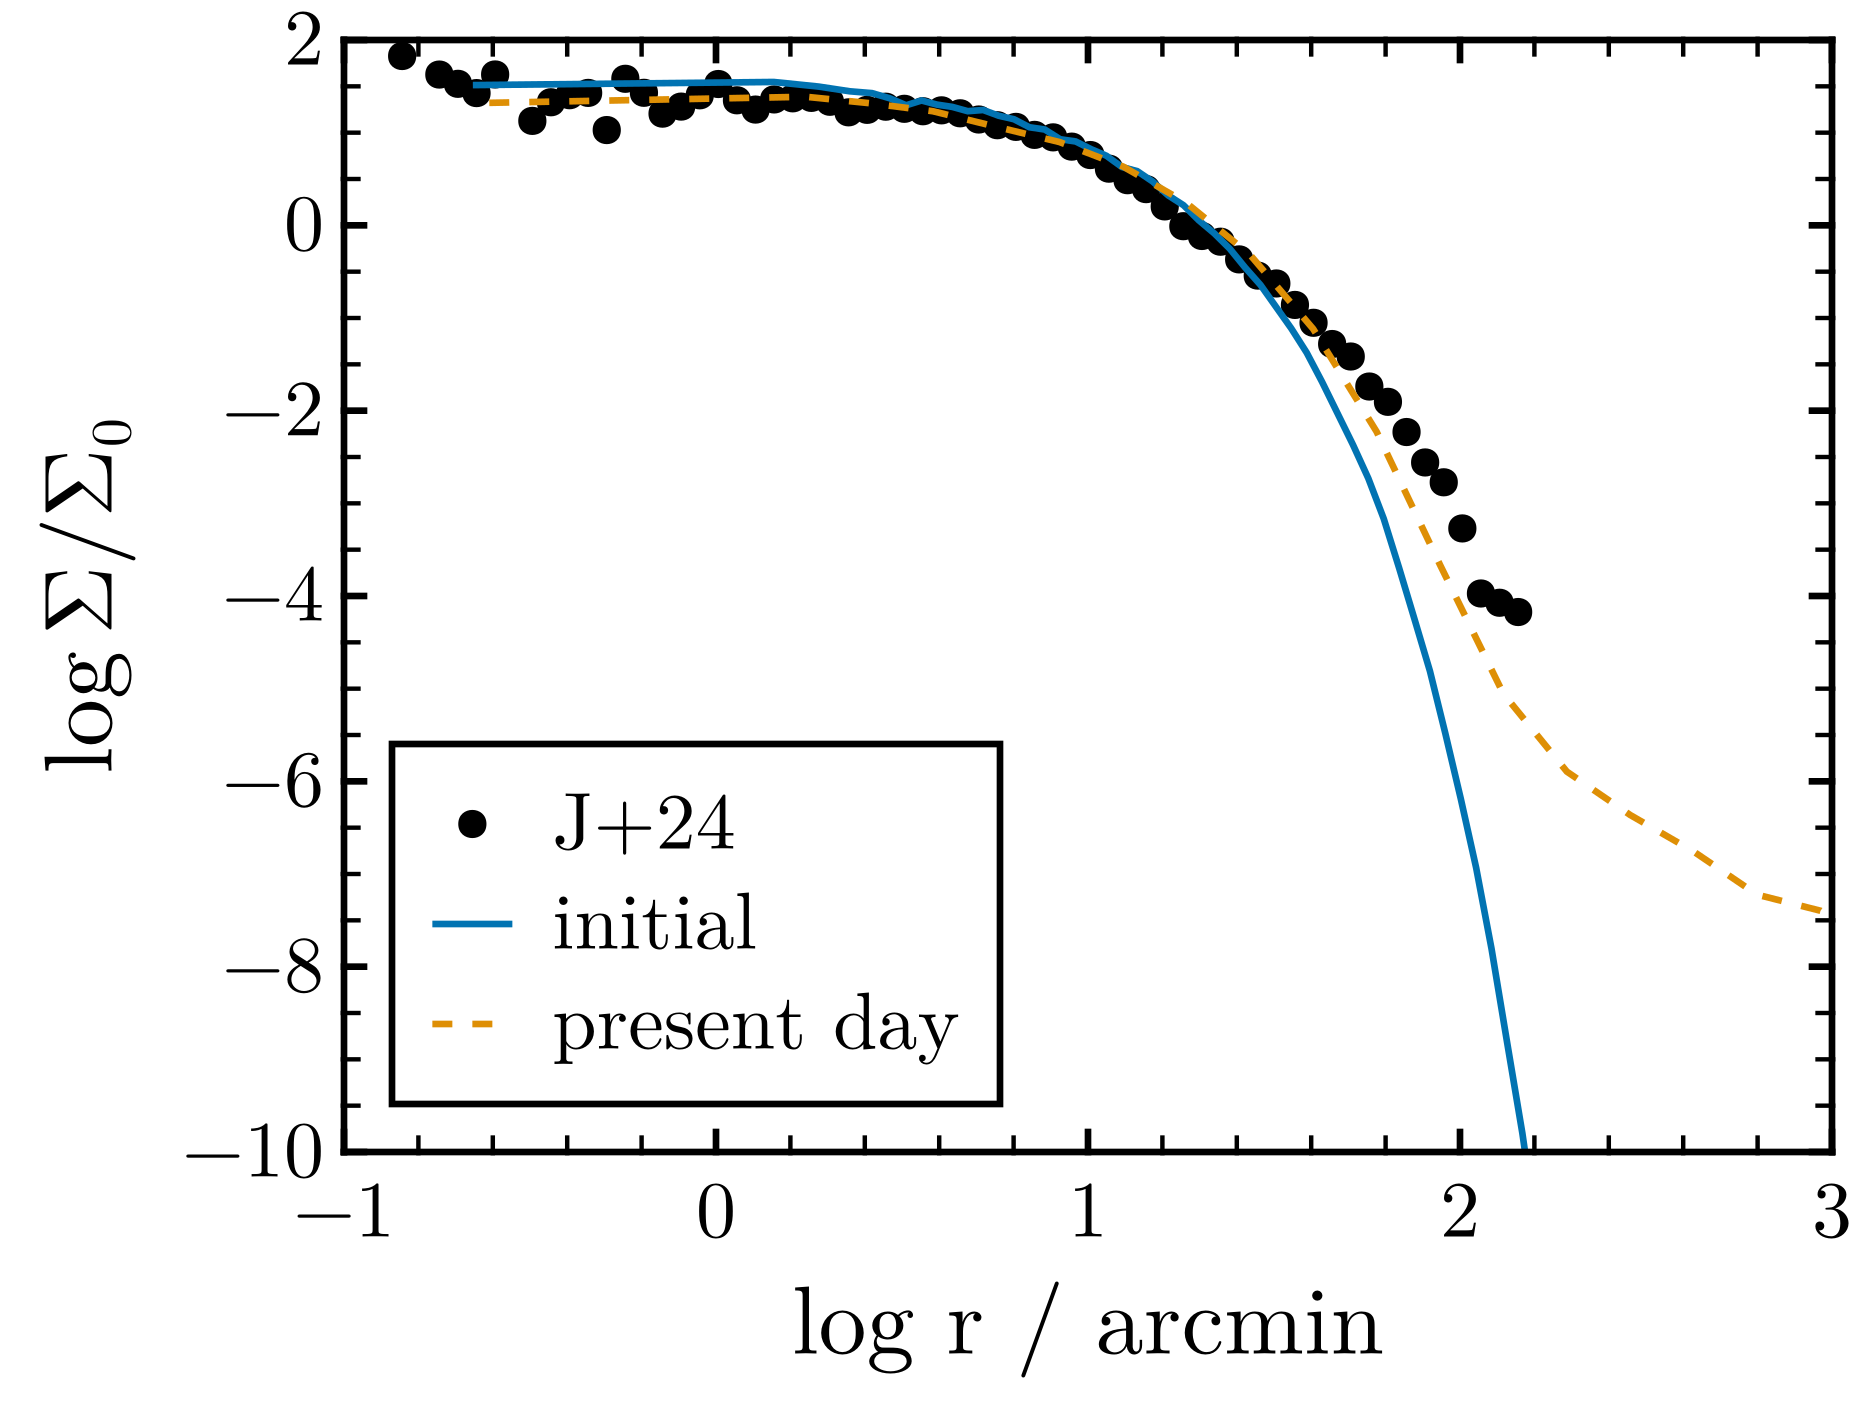

In [47]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -10, 2))#, r_b=r_b_arcmin)



In [55]:
modeldir = "1e6_new_v25_r2.5/orbit_smallperi"

"1e6_new_v25_r2.5/orbit_smallperi"

In [56]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

Dict{String, Any} with 18 entries:
  "theta0"            => -39.7928
  "idx_peris"         => [18, 53, 87, 121, 155, 188]
  "dec_f"             => -35.6832
  "pmra_f"            => 0.138396
  "t_f_gyr"           => 0.0437933
  "radial_velocity_f" => -0.190999
  "t_last_peri"       => 0.470994
  "apocentre"         => [95.3073, 94.9183, 94.7306, 94.5512, 94.4414]
  "period"            => 1.60309
  "pericentre"        => 43.0883
  "idx_peri"          => 188
  "idx_f"             => 198
  "idx_apos"          => [35, 70, 104, 138, 172, 205]
  "t_peris"           => [170.024, 519.907, 859.956, 1200.0, 1540.05, 1870.01]
  "pmdec_f"           => -0.190999
  "distance_f"        => 80.825
  "t_apos"            => [340.049, 689.932, 1029.98, 1370.03, 1710.08, 2040.03]
  "ra_f"              => 16.9805

In [57]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [58]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

# r_b = lguys.break_radius(prof_f. / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
# r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


[ Info: max radius of 0.7562998393788792
[ Info: max radius of 0.0973301388610367


3.783122854857954

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -10, 2))#, r_b=r_b_arcmin)



# 1e7 

## Mean orbit

In [32]:
modeldir = "1e7_V31_r3.2/orbit_smallperi"

"1e7_V31_r3.2/orbit_smallperi"

In [33]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

Dict{String, Any} with 15 entries:
  "theta0"      => -40.1688
  "idx_peris"   => [18, 52, 86, 119, 152, 185]
  "t_f_gyr"     => 9.14655
  "t_last_peri" => 0.470994
  "apocentre"   => [94.3355, 93.6349, 93.2365, 93.0251, 92.9393]
  "period"      => 1.57478
  "pericentre"  => 42.204
  "idx_peri"    => 185
  "idx_f"       => 195
  "idx_apos"    => [35, 69, 102, 135, 169, 202]
  "t_peris"     => [170.024, 510.073, 850.122, 1180.08, 1510.03, 1839.99]
  "dec0"        => -35.9839
  "distance_f"  => 81.053
  "ra0"         => 17.3597
  "t_apos"      => [340.049, 680.098, 1010.05, 1340.01, 1680.06, 2010.01]

### Exp2d(Rs=0.10)

In [36]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [38]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

# r_b = lguys.break_radius(prof_f. / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
# r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


[ Info: max radius of 0.7562998393788792
[ Info: max radius of 0.022255136115478427


3.7016324837311387

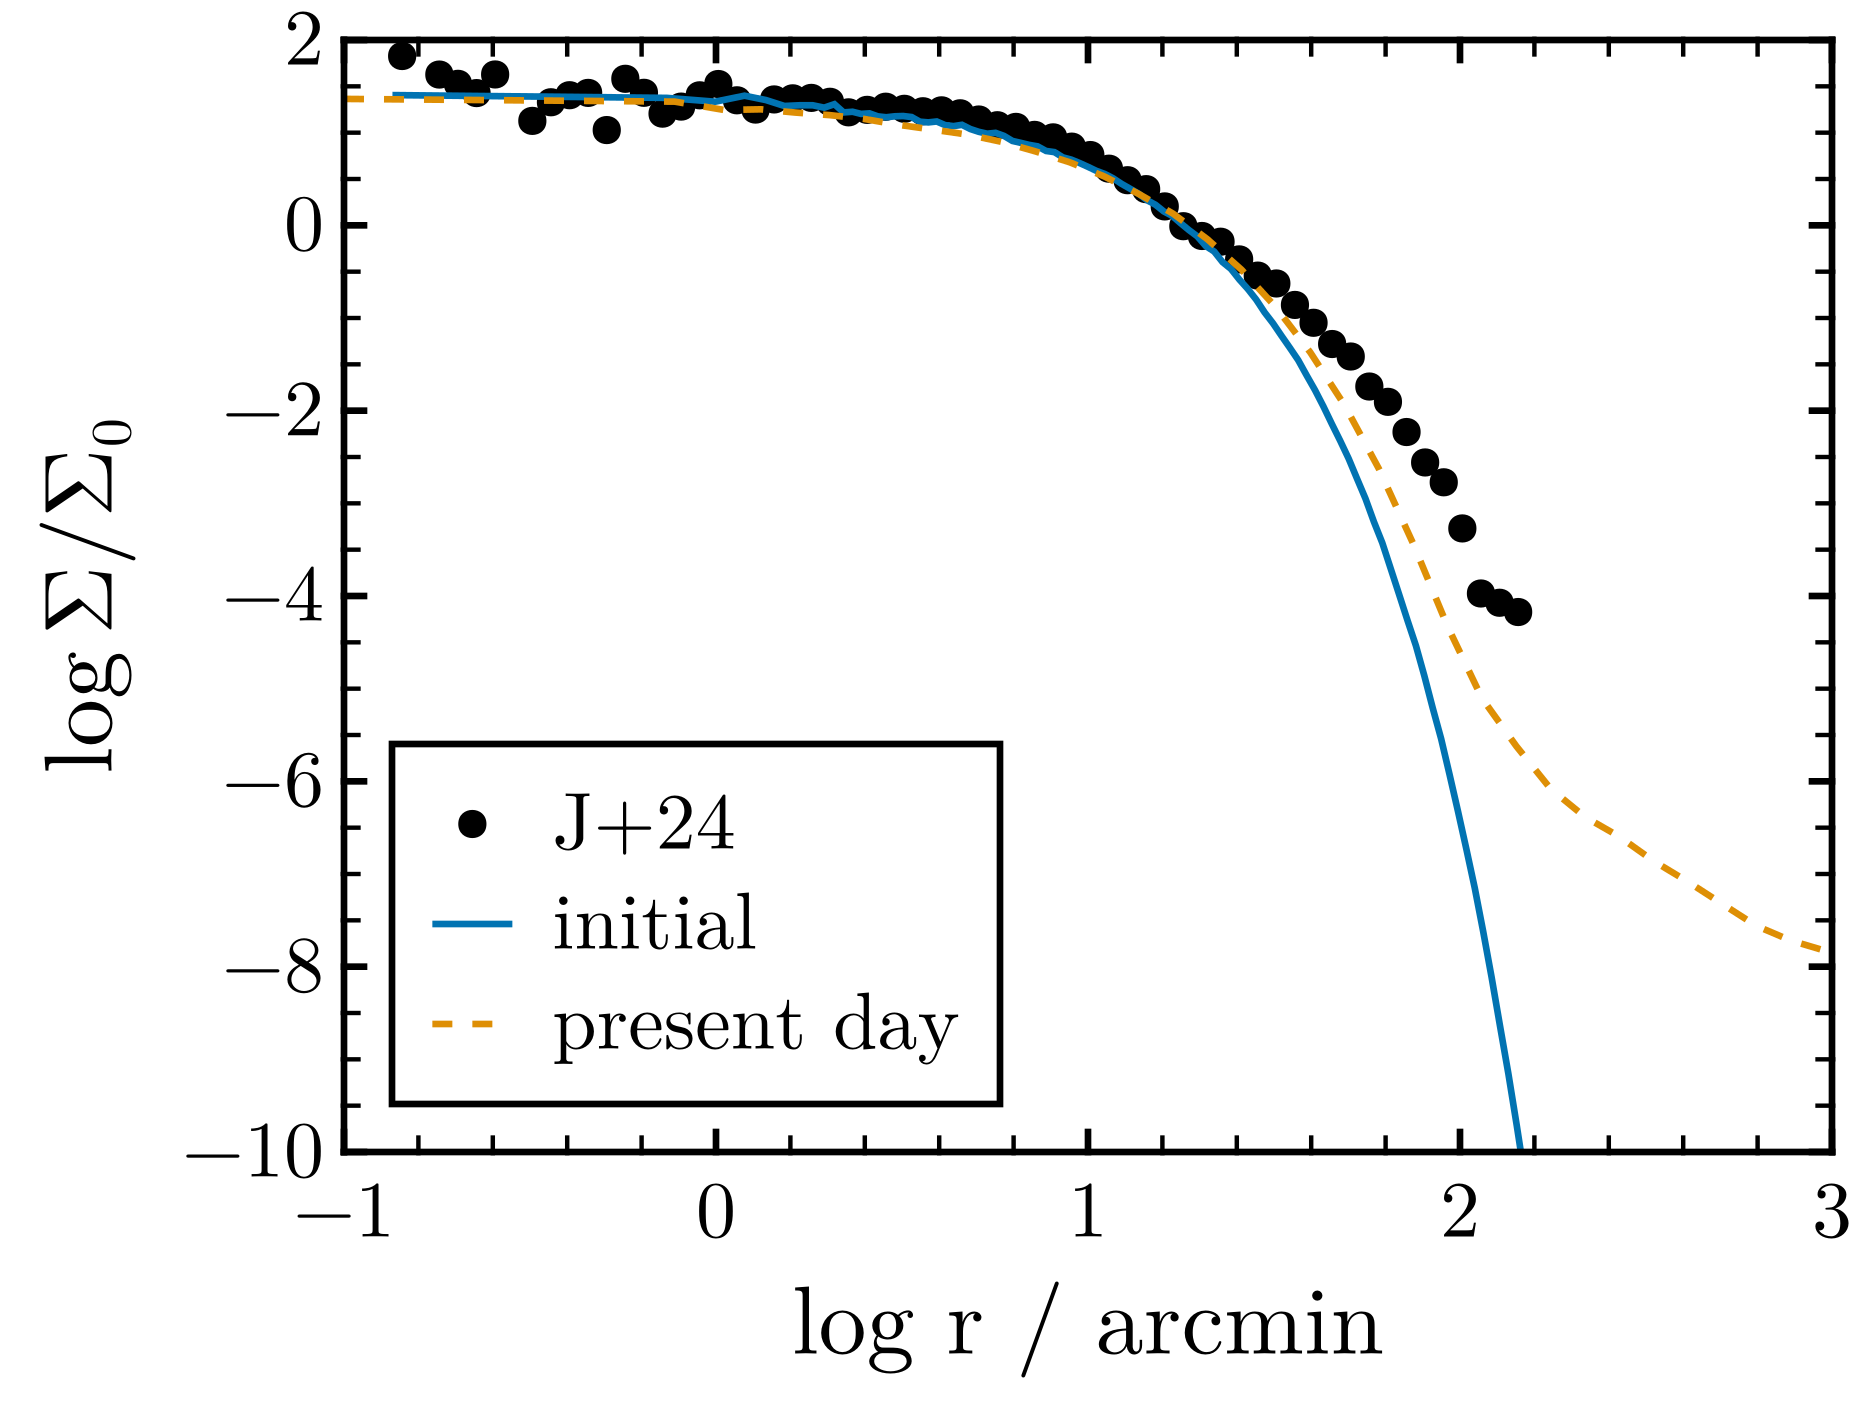

In [39]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -10, 2))#, r_b=r_b_arcmin)



### Exp2d(Rs=0.13)

In [108]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.11");

LoadError: UndefKeywordError: keyword argument `R_units` not assigned

In [109]:
profs = read_profiles_simple(modeldir, "exp2d_rs0.11");

LoadError: UndefVarError: `StellarProfile` not defined in `LilGuys`
Suggestion: check for spelling errors or missing imports.

In [103]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


LoadError: UndefVarError: `profs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [104]:
plot_ini_fin(profs, nothing, norm, limits=(-1, 3, -10, 2), r_b=r_b_arcmin,
    title="Exp2D(Rs=0.13 kpc)",
)



LoadError: UndefVarError: `r_b_arcmin` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Exp2d, Rs=0.15

### plummer

In [130]:
profs = read_profiles_simple(modeldir, "plummer_rs0.20");

LoadError: UndefVarError: `StellarProfile` not defined in `LilGuys`
Suggestion: check for spelling errors or missing imports.

In [134]:
profs, expected = read_profiles(modeldir, "plummer_rs0.25");

LoadError: "/cosma/home/durham/dc-boye1/data/dwarfs/analysis/sculptor/1e7_V31_r3.2/orbit_smallperi/stars/plummer_rs0.25/initial_profile.toml": No such file

In [135]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


[ Info: max radius of 0.7562998393788792
[ Info: max radius of 0.011312528162684375


LoadError: UndefVarError: `calc_break_radius` not defined in `LilGuys`
Suggestion: check for spelling errors or missing imports.

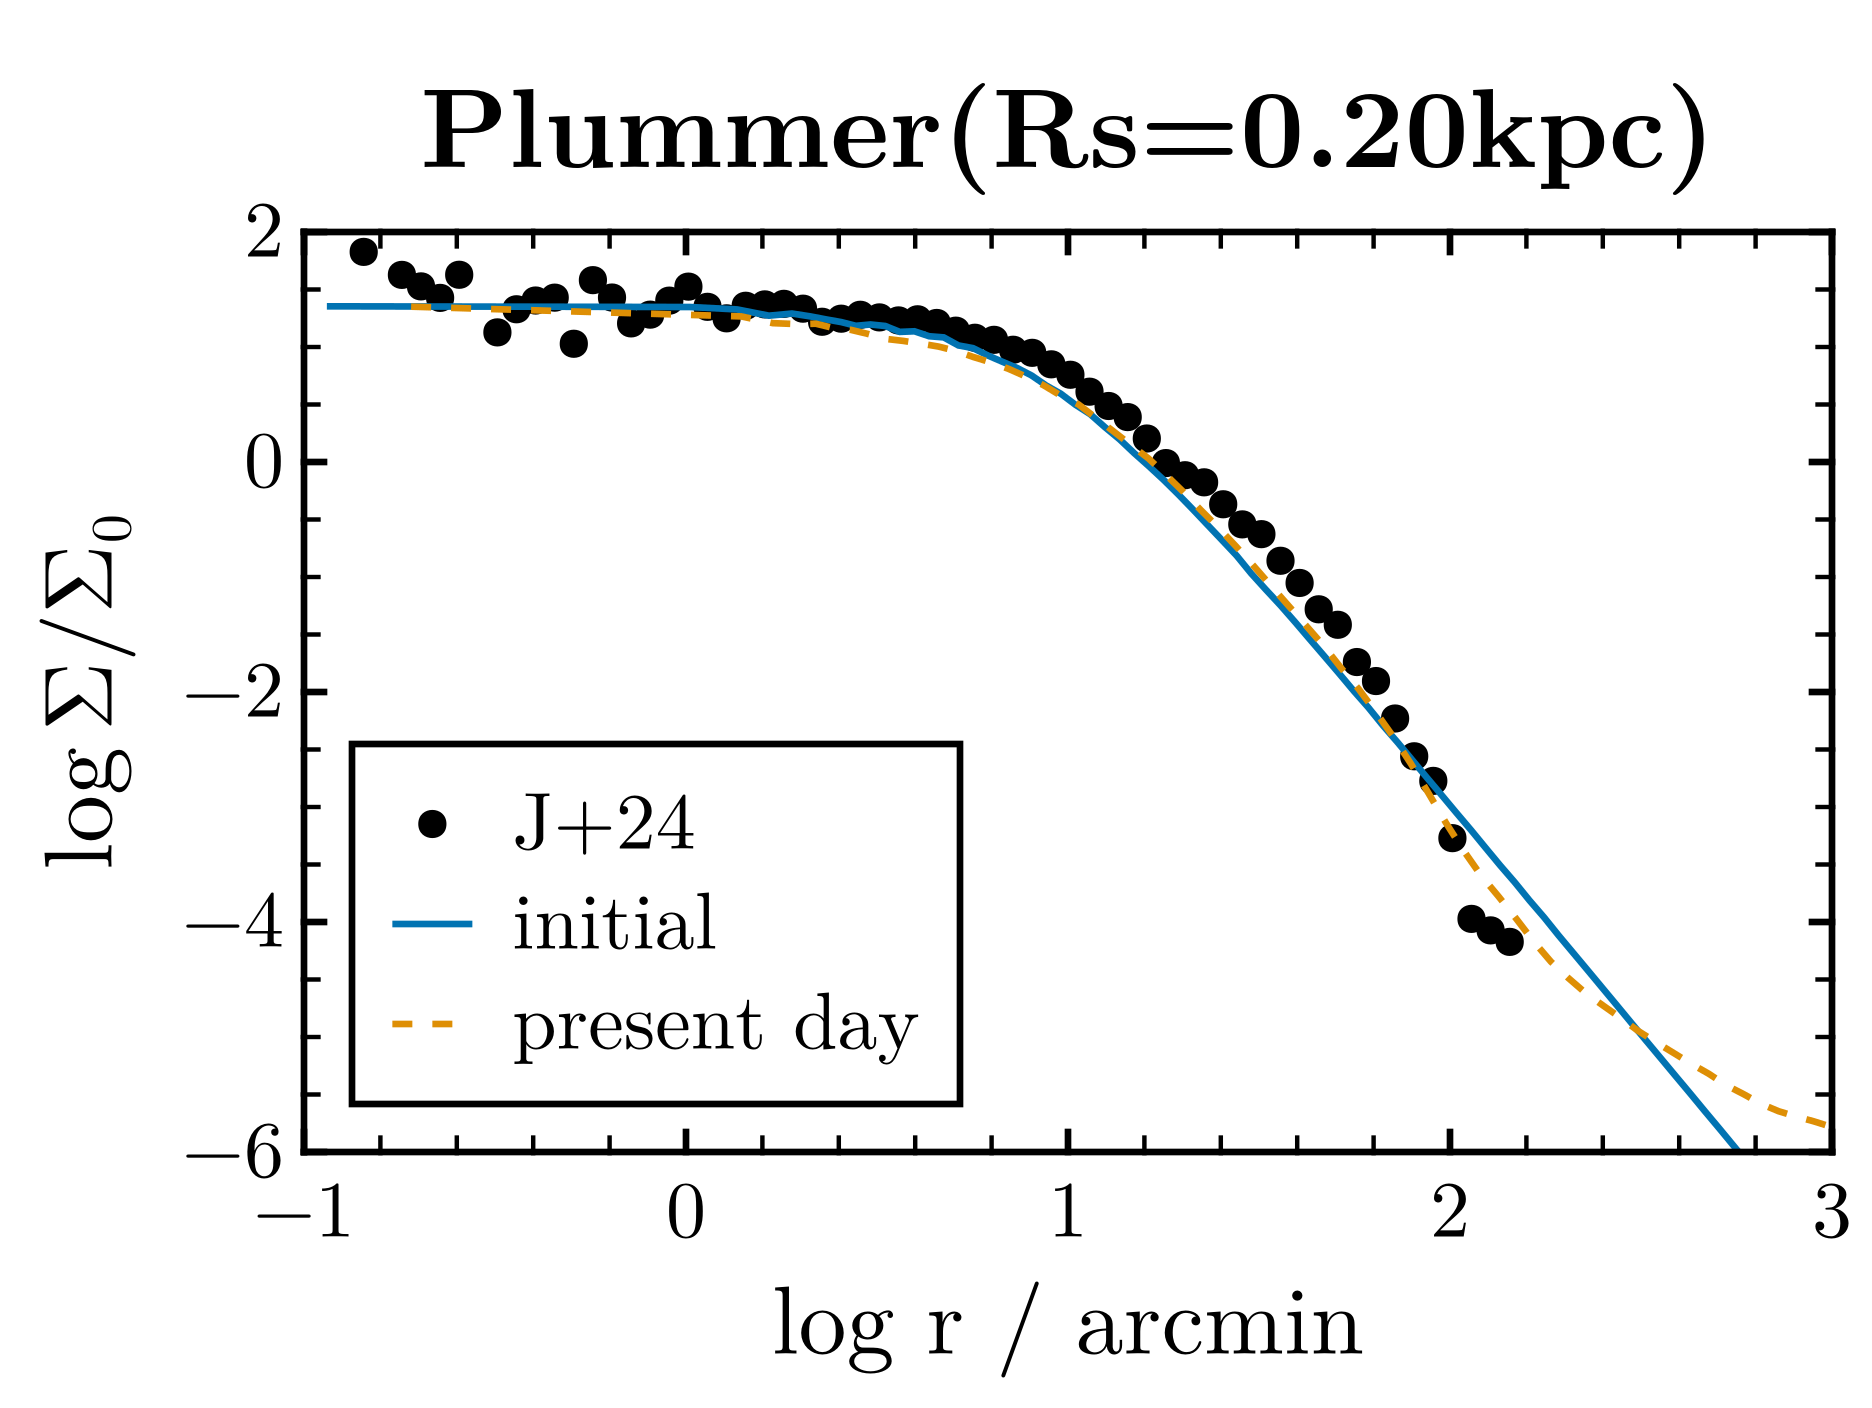

In [136]:
fig = plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2),title="Plummer(Rs=0.20kpc)")



In [ ]:
prof_1e7 = profs[end]

In [ ]:
plot_ini_fin(profs[1:5], expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin, title="Plummer(Rs=0.20kpc)")



## SmallperiLMC

In [ ]:
modeldir = "1e7_V31_r4.2/vasiliev24_L3M11_2x_smallperilmc"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

### Exp2d

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


In [ ]:
plot_ini_fin(profs, nothing, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin,
    title="Exp2D(Rs=0.13 kpc)",
)



In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2.1, -12, 4), binsize=5, r_b=r_b_arcmin)

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.08");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


In [ ]:
plot_ini_fin(profs, nothing, norm, limits=(-1, 3, -10, 2), r_b=r_b_arcmin,
    title="Exp2D(Rs=0.08 kpc)",
)



In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2.1, -12, 4), binsize=5, r_b=r_b_arcmin)

# 1e6

## Mean mean

In [ ]:
modeldir = "sculptor/1e6_V31_r3.2/orbit1"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

### Plummer 0.15

In [ ]:
profs, expected = read_profiles(modeldir, "plummer_rs0.15");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

### Plummer 0.20

In [ ]:
profs, expected = read_profiles(modeldir, "plummer_rs0.20");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm - 0.1, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

## SmallPeri

In [ ]:
modeldir = "sculptor/1e6_V31_r3.2/orbit_smallperi"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

### Exponential

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.10");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -10, 2), r_b=r_b_arcmin)

### plummer

In [ ]:
profs, expected = read_profiles(modeldir, "plummer_rs0.20");

In [ ]:
profs[1].second.M_in[profs[1].second.log_r .> 2]

In [ ]:
profs[end].second.M_in[profs[end].second.log_r .> 2]

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
prof_1e7 = "mean orbit final (1e7)" => prof_1e7.second

In [ ]:
append!(profs, [prof_1e7])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

## LMC

In [ ]:
modeldir = "sculptor/1e6_V31_r3.2/vasiliev+21_mean"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

In [ ]:
profs, expected = read_profiles(modeldir, "plummer_rs0.20");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 3, -10, 4), binsize=5, r_b=r_b_arcmin)

### Exponential

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 2, -4, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2, -10, 4), binsize=5, r_b=r_b_arcmin)

## LMC small

In [ ]:
modeldir = "sculptor/1e6_V31_r3.2/vasiliev+21_smallperi"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

In [ ]:
profs, expected = read_profiles(modeldir, "plummer_rs0.20");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 3, -10, 4), binsize=5, r_b=r_b_arcmin)

### Exponential

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 2, -4, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2, -10, 4), binsize=5, r_b=r_b_arcmin)

## LMC small + light

In [ ]:
modeldir = "sculptor/1e6_V31_r4.2/vasiliev+21_smallperi"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

In [ ]:
profs, expected = read_profiles(modeldir, "plummer_rs0.20");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2.5, -10, 4), binsize=5, r_b=r_b_arcmin)

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2.5, -10, 4), binsize=5, r_b=r_b_arcmin)

## HeavyLMC

In [ ]:
modeldir = "sculptor/1e6_V31_r3.2/vasiliev+21_heavylmc_smallperilmc"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

### Plummer

In [ ]:
profs, expected = read_profiles(modeldir, "plummer_rs0.20");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 3, -10, 4), binsize=5, r_b=r_b_arcmin)

### Exp2d

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2, -10, 4), binsize=5, r_b=r_b_arcmin)

## Heavy LMC II

In [ ]:
modeldir = "sculptor/1e6_V31_r3.2/vasiliev24_L2M11_extremeperi"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

### Plummer

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


In [ ]:
plot_ini_fin(profs, nothing, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin,
)



## Heavy LMC III

In [ ]:
modeldir = "sculptor/1e6_V31_r3.2/vasiliev24_L3M11_extremeperi"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])


In [ ]:
plot_ini_fin(profs, nothing, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin,
)



The larger aparent exponential scale radius is due to a vastly different assumed final position.

## HeavyLMC mean

In [ ]:
modeldir = "sculptor/1e6_V31_r3.2/vasiliev+21_heavylmc"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

### Plummer

In [ ]:
profs, expected = read_profiles(modeldir, "plummer_rs0.20");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 3, -10, 4), binsize=5, r_b=r_b_arcmin)

### Exp2d

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2, -10, 4), binsize=5, r_b=r_b_arcmin)

# 1e6 expcusp

In [ ]:
modeldir = "1e6_expcusp/vasiliev24_L3M11_extremeperi"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2, -10, 4), binsize=5, r_b=r_b_arcmin)

# 1e6 cored

In [ ]:
modeldir = "1e6_V36_r4.8_c0.1/vasiliev24_L3M11_extremeperi"

In [ ]:
orbit_props = TOML.parsefile(joinpath(modeldir, "orbital_properties.toml"))

### Exp2d

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.13");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, 0.10 / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2, -10, 4), binsize=5, r_b=r_b_arcmin)

### Exp2d

In [ ]:
profs, expected = read_profiles(modeldir, "exp2d_rs0.08");

In [ ]:
prof_f = profs[end].second
norm = get_normalization(prof_f)

r_b = lguys.calc_break_radius(prof_f.sigma_v / lguys.V2KMS, orbit_props["t_last_peri"] / lguys.T2GYR)
r_b_arcmin = lguys.kpc_to_arcmin(r_b, orbit_props["distance_f"])

In [ ]:
plot_ini_fin(profs, expected, norm, limits=(-1, 3, -6, 2), r_b=r_b_arcmin)

In [ ]:
plot_ini_fin_slope(profs, expected, limits=(-1, 2, -10, 4), binsize=5, r_b=r_b_arcmin)